## Importar librerias

In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Noticias_BCRP/notebooks/")

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import FreqDist
from nltk import ngrams
from gensim.models.phrases import Phrases, Phraser

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/ScrapingProyectosLey/Codigos/src/')
from filter_words import run_stopword_statistics
from filter_words import make_stopwords_filter
from filter_words import remove_stopwords_from_list_texts

In [ ]:
stop_word=stopwords.words("spanish") ### obtener la lista de stopwords en idioma español
stop_word=[i.translate(str.maketrans('áéíóúü','aeiouu')) for i in stop_word]

### Cargar data

In [ ]:
df_noticias_bcrp_pdf=pd.read_pickle("../data/raw/df_noticias_bcrp_pdf.pkl")
df_noticias_bcrp_pdf=df_noticias_bcrp_pdf[df_noticias_bcrp_pdf["Archivo Origen"].str[-7:]!="Pg1.pdf"].copy()
df_noticias_bcrp_pdf=df_noticias_bcrp_pdf[df_noticias_bcrp_pdf["Texto"]!=""].copy()
print(df_noticias_bcrp_pdf.shape)
df_noticias_bcrp_pdf.head()

(44146, 3)


,Archivo Origen,Fecha,Texto
1,20160104094339_NOTICIAS-BCRP_20160104_Pg10.pdf,2016-01-04,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...
2,20160104094339_NOTICIAS-BCRP_20160104_Pg11.pdf,2016-01-04,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D..."
3,20160104094339_NOTICIAS-BCRP_20160104_Pg12.pdf,2016-01-04,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...
4,20160104094339_NOTICIAS-BCRP_20160104_Pg13.pdf,2016-01-04,% Departamento de Prensa\n\nLA RAZÓN\n\nRECOMI...
5,20160104094339_NOTICIAS-BCRP_20160104_Pg14.pdf,2016-01-04,“D 7 Páginas\na /\n\n%Depanamento de Prensa EL...


In [ ]:
df_noticias_bcrp_gestion=pd.read_pickle("../data/raw/df_noticias_bcr_gestion.pkl").rename(columns={"texto":"Texto"})
print(df_noticias_bcrp_gestion.shape)
df_noticias_bcrp_gestion.head()

(4713, 5)


,fuente,fecha,url,titulo,Texto
0,gestion,2020-04-17T13:22:21-05:00,https://gestion.pe/economia/reactiva-peru-bcr-...,Reactiva Perú: BCR cobrará tasa de interés de...,El Banco Central de Reserva del Perú (BCR) asi...
1,gestion,2020-04-17T11:38:26-05:00,https://gestion.pe/economia/se-registra-defici...,"Perú registró déficit fiscal de S/ 2,391 mill...",Según el último Resumen Informativo Semanal pu...
2,gestion,2020-04-17T05:59:39-05:00,https://gestion.pe/economia/mef-reactiva-peru-...,El vía crucis de Reactiva Perú: Falta revisió...,"Según la ministra de Economía, María Antonieta..."
3,gestion,2020-04-16T18:51:31-05:00,https://gestion.pe/economia/reservas-internaci...,Reservas internacionales superaron los US$ 70...,Las Reservas Internacionales Netas (RIN) al 15...
4,gestion,2020-04-16T05:14:12-05:00,https://gestion.pe/economia/tasas-de-interes-d...,Tasas de interés de créditos del programa Rea...,Las tasas de interés de los créditos del progr...


In [ ]:
df_noticias_bcrp=pd.concat([df_noticias_bcrp_pdf[["Texto"]],df_noticias_bcrp_gestion[["Texto"]]],axis=0)
df_noticias_bcrp.index=[ i for i in range(0,len(df_noticias_bcrp))]

### Limpieza y remover stopwords

In [ ]:
def clean_text_noticias(news):
    clean_news = []
    for new in news:
        sin_guiones=re.sub('(\S)-\n', r'\1', new.lower()) ### sin guiones
        # sin_guiones=re.sub('(\S)\n-', r'\1', sin_guiones.lower()) ### sin guiones
        sin_character = re.sub(r'[^\w\s]', '', sin_guiones) ##busca los signos, caracteristicas especiales
        sin_numero = re.sub("\d+", "", sin_character)##busca los numeros y los elimina
        sin_tildes=sin_numero.translate(str.maketrans('áéíóúü','aeiouu'))
        sin_tildes = " ".join([i.strip() for i in sin_tildes.split() if len(i)>2])##solo palabras que tengan mas de tres caracteres
        clean_news.append(sin_tildes)     
    return clean_news
df_noticias_bcrp["Texto_Limpio"]=clean_text_noticias(df_noticias_bcrp["Texto"])
print(df_noticias_bcrp.shape)
df_noticias_bcrp.head()

(48859, 3)


,Texto,Texto_Limpio,Texto_Stopwords
0,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...,diz finanzas momento reestructurar las deudas ...,diz finanzas momento reestructurar deudas peia...
1,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D...",xºq denartamento prensa alueves icembreoel rep...,xºq denartamento prensa alueves icembreoel rep...
2,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...,tro economista gontalez izquierdo recomiendan ...,tro economista gontalez izquierdo recomiendan ...
3,% Departamento de Prensa\n\nLA RAZÓN\n\nRECOMI...,departamento prensa razon recomienda gonzalez ...,departamento prensa razon recomienda gonzalez ...
4,“D 7 Páginas\na /\n\n%Depanamento de Prensa EL...,paginas depanamento prensa omercio ehe kms dia...,paginas depanamento prensa omercio ehe kms dia...


In [ ]:
def remove_stopwords(news,stop_word):
    sin_stopwords=[]
    for new in news:
        content=[word for word in new.split() if word not in stop_word]
        sin_stopwords.append(" ".join(content))
    return sin_stopwords
df_noticias_bcrp["Texto_Stopwords"]=remove_stopwords(df_noticias_bcrp["Texto_Limpio"],stop_word)
print(df_noticias_bcrp.shape)
df_noticias_bcrp.head()

(48859, 3)


,Texto,Texto_Limpio,Texto_Stopwords
0,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...,diz finanzas momento reestructurar las deudas ...,diz finanzas momento reestructurar deudas peia...
1,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D...",xºq denartamento prensa alueves icembreoel rep...,xºq denartamento prensa alueves icembreoel rep...
2,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...,tro economista gontalez izquierdo recomiendan ...,tro economista gontalez izquierdo recomiendan ...
3,% Departamento de Prensa\n\nLA RAZÓN\n\nRECOMI...,departamento prensa razon recomienda gonzalez ...,departamento prensa razon recomienda gonzalez ...
4,“D 7 Páginas\na /\n\n%Depanamento de Prensa EL...,paginas depanamento prensa omercio ehe kms dia...,paginas depanamento prensa omercio ehe kms dia...


## Ngrams

In [ ]:
# from gensim.models.phrases import Phrases, Phraser
# phrases = Phrases(sentences, min_count=5, threshold=10)
# bigram = Phraser(phrases)
# for sent in sentences:
#     sentence_bigrams.append(bigram[sent])
#     sentence_trigrams.append(trigram[bigram[sent]])

In [ ]:
# common_terms=stop_word
# common_terms=stop_word
### texto limpio

In [ ]:
from gensim.models.phrases import Phrases, Phraser
sentences=[ i.split() for i in df_noticias_bcrp["Texto_Stopwords"]] 
phrases = Phrases(sentences, min_count=5, threshold=10)
bigram = Phraser(phrases)
phrases = Phrases(bigram[sentences], min_count=5, threshold=10)
trigram = Phraser(phrases)
sentences_unigrams=sentences
sentence_bigrams=[]
sentence_trigrams=[]
for sent in sentences:
    sentence_bigrams.append(bigram[sent])
    sentence_trigrams.append(trigram[bigram[sent]])

In [ ]:
# ## Mostrando los ngramas
# Ngrams  = ngrams(" ".join(df_noticias_bcrp["Texto_Stopwords"]).split(), 2)
# frequencies_ngrams = FreqDist( Ngrams )
# frequencies_ngrams.most_common(10)
# len(frequencies_ngrams) , len(bigram.phrasegrams)
# len(bigram.phrasegrams)/len(frequencies_ngrams) ###bigram
# frequencies_unigrams = FreqDist( " ".join(df_noticias_bcrp["Texto_Stopwords"]).split())
# len(frequencies_unigrams)
# frequencies_unigrams["_moneda"]
#  (b'departamento', b'prensa'): (28569, 149.48977168752916)
#  (28569-5)*(807106+4320505-23184)/(30228*32266)

In [ ]:
df1=df_noticias_bcrp
df2=df_noticias_bcrp
df3=df_noticias_bcrp

### Unigrams

In [ ]:
N_s = 10
df_statistics = run_stopword_statistics(sentences_unigrams,N_s=N_s)
df_statistics.sort_values(by='F',ascending=False).head()
df_statistics

,F,I,tfidf,H,H-tilde,H-tilde_std,N
___,4.766745e-05,2.546215e-01,5.610904,8.377603,8.632225,7.502070e-03,399
____,3.703486e-06,0.000000e+00,7.362707,4.954196,4.954196,8.429370e-08,31
_____,1.792010e-06,0.000000e+00,8.088644,3.906891,3.906891,5.960464e-08,15
______,1.433608e-06,0.000000e+00,8.311787,3.584963,3.584963,0.000000e+00,12
_______,1.075206e-06,4.440892e-16,8.599469,3.169925,3.169925,0.000000e+00,9
...,...,...,...,...,...,...,...
ññz,2.389346e-07,-1.110223e-16,10.103547,1.000000,1.000000,1.053671e-08,2
ñññj_,1.194673e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1
ññño,1.194673e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1
ñññz,1.194673e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1


In [ ]:
## seleccionando el metodo de remover stopwords
method = 'INFOR'
cutoff_type = 'p'
cutoff_val = 0.60
df_filter = make_stopwords_filter(df_statistics,
                                  method = method,
                                  cutoff_type = cutoff_type, 
                                  cutoff_val = cutoff_val )

In [ ]:
list_words_filter = list(df_filter.index)
list_texts_filter = remove_stopwords_from_list_texts(sentences_unigrams, list_words_filter)

In [ ]:
df1["Clean_Stopword_Info"]=[" ".join(i).strip() for i in list_texts_filter]
df1.head()

,Texto,Texto_Limpio,Texto_Stopwords,Clean_Stopword_Info
0,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...,diz finanzas momento reestructurar las deudas ...,diz finanzas momento reestructurar deudas peia...,deudas costo financiamiento empresas años tasa...
1,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D...",xºq denartamento prensa alueves icembreoel rep...,xºq denartamento prensa alueves icembreoel rep...,ene construccion gasoducto sur publico privada...
2,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...,tro economista gontalez izquierdo recomiendan ...,tro economista gontalez izquierdo recomiendan ...,izquierdo tipo cambio ahorrar jorge gonzalez i...
3,% Departamento de Prensa\n\nLA RAZÓN\n\nRECOMI...,departamento prensa razon recomienda gonzalez ...,departamento prensa razon recomienda gonzalez ...,gonzalez izquierdo tipo cambio jorge gonzalez ...
4,“D 7 Páginas\na /\n\n%Depanamento de Prensa EL...,paginas depanamento prensa omercio ehe kms dia...,paginas depanamento prensa omercio ehe kms dia...,kms dolar precio metales


In [ ]:
df1["Num_Words"]=df1["Clean_Stopword_Info"].apply(lambda x:len(x.split()))
df1["Num_Words"].describe()

count    48859.000000
mean        68.570335
std         47.970349
min          0.000000
25%         33.000000
50%         61.000000
75%         94.000000
max        504.000000
Name: Num_Words, dtype: float64

In [ ]:
df1=df1[df1["Num_Words"]>=25].copy()
print(df1.shape)
df1.head()

(40586, 5)


,Texto,Texto_Limpio,Texto_Stopwords,Clean_Stopword_Info,Num_Words
0,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...,diz finanzas momento reestructurar las deudas ...,diz finanzas momento reestructurar deudas peia...,deudas costo financiamiento empresas años tasa...,78
1,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D...",xºq denartamento prensa alueves icembreoel rep...,xºq denartamento prensa alueves icembreoel rep...,ene construccion gasoducto sur publico privada...,248
2,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...,tro economista gontalez izquierdo recomiendan ...,tro economista gontalez izquierdo recomiendan ...,izquierdo tipo cambio ahorrar jorge gonzalez i...,69
5,- 4 ENEL 2016 pégna 22\n\nFecha\n\nGESTIÓN\n\n...,enel pegna fecha gestion departamento prensa d...,enel pegna fecha gestion departamento prensa d...,inversionistas estrategia oportunidades accion...,110
6,"SiegoHarrero,geren-\ntedeinversionesde AFP\nHa...",siegoharrerogerentedeinversionesde afp habitat...,siegoharrerogerentedeinversionesde afp habitat...,afp activo desarrollados europa japon cambiari...,140


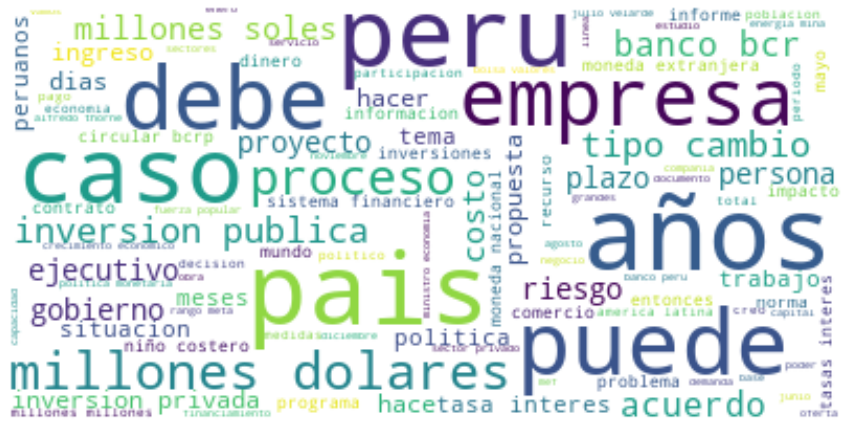

In [ ]:
### wordcloud de palabras recurrentes
plt.figure(figsize=(15,15))
wordcloud = WordCloud(max_words=100,min_font_size=5,max_font_size=50,background_color="white").generate(" ".join(df1["Clean_Stopword_Info"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

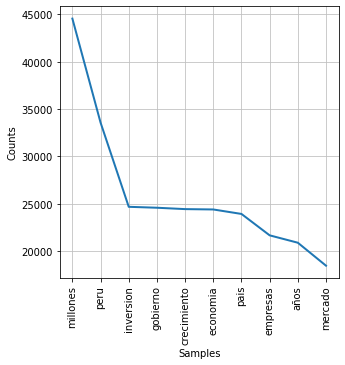

None


In [ ]:
## Histogramas de palabras mas frecuentes
plt.figure(figsize=(5,5))
frequencies = FreqDist( " ".join(df1["Clean_Stopword_Info"]).split() )
plot = frequencies.plot( 10 )
print(plot)

In [ ]:
## Mostrando los ngramas
Ngrams  = ngrams(" ".join(df1["Clean_Stopword_Info"]).split(), 3)
frequencies = FreqDist( Ngrams )
frequencies.most_common(10)

[(('bolsa', 'valores', 'lima'), 1222),
 (('repo', 'compra', 'compromiso'), 1151),
 (('compra', 'compromiso', 'recompra'), 1128),
 (('banca', 'seguros', 'afp'), 1089),
 (('bcr', 'julio', 'velarde'), 851),
 (('tasa', 'interes', 'referencia'), 841),
 (('valores', 'lima', 'bvl'), 831),
 (('economia', 'alfredo', 'thorne'), 788),
 (('ministro', 'economia', 'alfredo'), 763),
 (('soles', 'bancos', 'soles'), 747)]

In [ ]:
df1.to_pickle("../data/cleaned/df_noticias_bcrp_cleanedInfo.pkl")

In [ ]:
df1.to_pickle("../data/intermediated/df_statistics_bcrp.pkl")

### Bigrams

In [ ]:
N_s = 10
df_statistics = run_stopword_statistics(sentence_bigrams,N_s=N_s)
df_statistics.sort_values(by='F',ascending=False).head()
df_statistics

,F,I,tfidf,H,H-tilde,H-tilde_std,N
___,4.993483e-05,1.773187e-01,5.525441,8.254292,8.431610,7.709813e-03,349
____,4.435472e-06,-6.451613e-03,7.362707,4.954196,4.947745,1.935484e-02,31
_____,2.146196e-06,0.000000e+00,8.088644,3.906891,3.906891,5.960464e-08,15
______,1.716957e-06,0.000000e+00,8.311787,3.584963,3.584963,0.000000e+00,12
_______,1.860037e-06,-8.881784e-16,8.231745,3.700440,3.700440,8.429370e-08,13
...,...,...,...,...,...,...,...
ññz,2.861595e-07,-1.110223e-16,10.103547,1.000000,1.000000,1.053671e-08,2
ñññj_,1.430797e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1
ññño,1.430797e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1
ñññz,1.430797e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1


In [ ]:
## seleccionando el metodo de remover stopwords
method = 'INFOR'
cutoff_type = 'p'
cutoff_val = 0.60
df_filter = make_stopwords_filter(df_statistics,
                                  method = method,
                                  cutoff_type = cutoff_type, 
                                  cutoff_val = cutoff_val )

In [ ]:
list_words_filter = list(df_filter.index)
list_texts_filter = remove_stopwords_from_list_texts(sentence_bigrams, list_words_filter)

In [ ]:
df2["Clean_Stopword_Info"]=[" ".join(i).strip() for i in list_texts_filter]
df2.head()

,Texto,Texto_Limpio,Texto_Stopwords,Clean_Stopword_Info,Num_Words
0,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...,diz finanzas momento reestructurar las deudas ...,diz finanzas momento reestructurar deudas peia...,costo_financiamiento empresas subida_tasa poli...,66
1,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D...",xºq denartamento prensa alueves icembreoel rep...,xºq denartamento prensa alueves icembreoel rep...,republica mes construccion gasoducto_sur perua...,182
2,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...,tro economista gontalez izquierdo recomiendan ...,tro economista gontalez izquierdo recomiendan ...,economista izquierdo tipo_cambio ahorrar gonza...,50
3,% Departamento de Prensa\n\nLA RAZÓN\n\nRECOMI...,departamento prensa razon recomienda gonzalez ...,departamento prensa razon recomienda gonzalez ...,gonzalez_izquierdo tipo_cambio gonzalez_izquie...,12
4,“D 7 Páginas\na /\n\n%Depanamento de Prensa EL...,paginas depanamento prensa omercio ehe kms dia...,paginas depanamento prensa omercio ehe kms dia...,kms dolar,2


In [ ]:
df2["Num_Words"]=df2["Clean_Stopword_Info"].apply(lambda x:len(x.split()))
df2["Num_Words"].describe()

count    48859.000000
mean        57.218936
std         41.733929
min          0.000000
25%         25.000000
50%         51.000000
75%         81.000000
max        470.000000
Name: Num_Words, dtype: float64

In [ ]:
df2=df2[df2["Num_Words"]>=15].copy()
print(df2.shape)
df2.head()

(41861, 5)


,Texto,Texto_Limpio,Texto_Stopwords,Clean_Stopword_Info,Num_Words
0,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...,diz finanzas momento reestructurar las deudas ...,diz finanzas momento reestructurar deudas peia...,costo_financiamiento empresas subida_tasa poli...,66
1,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D...",xºq denartamento prensa alueves icembreoel rep...,xºq denartamento prensa alueves icembreoel rep...,republica mes construccion gasoducto_sur perua...,182
2,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...,tro economista gontalez izquierdo recomiendan ...,tro economista gontalez izquierdo recomiendan ...,economista izquierdo tipo_cambio ahorrar gonza...,50
5,- 4 ENEL 2016 pégna 22\n\nFecha\n\nGESTIÓN\n\n...,enel pegna fecha gestion departamento prensa d...,enel pegna fecha gestion departamento prensa d...,enel gestion inversionistas estrategia porcent...,106
6,"SiegoHarrero,geren-\ntedeinversionesde AFP\nHa...",siegoharrerogerentedeinversionesde afp habitat...,siegoharrerogerentedeinversionesde afp habitat...,afp activo internacional acciones_europeas cob...,148


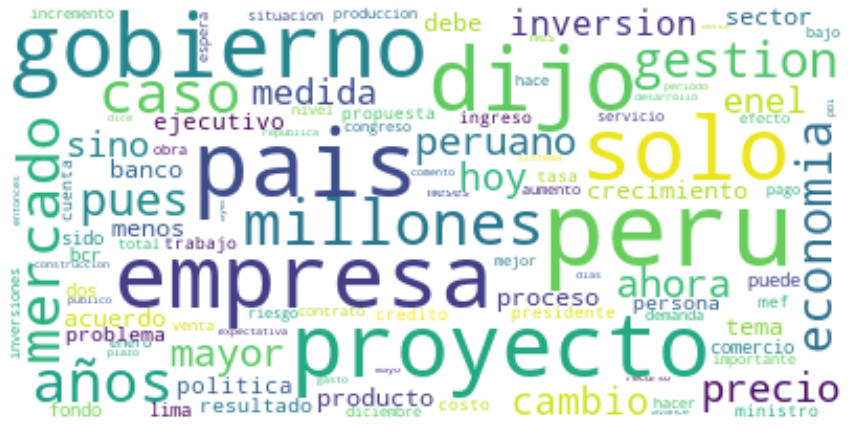

In [ ]:
### wordcloud de palabras recurrentes
plt.figure(figsize=(15,15))
wordcloud = WordCloud(max_words=100,min_font_size=5,max_font_size=50,background_color="white").generate(" ".join(df2["Clean_Stopword_Info"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

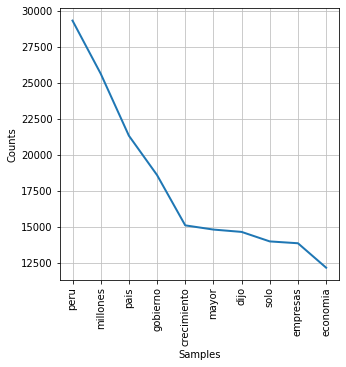

None


In [ ]:
## Histogramas de palabras mas frecuentes
plt.figure(figsize=(5,5))
frequencies = FreqDist( " ".join(df2["Clean_Stopword_Info"]).split() )
plot = frequencies.plot( 10 )
print(plot)

In [ ]:
## Mostrando los ngramas
Ngrams  = ngrams(" ".join(df2["Clean_Stopword_Info"]).split(), 2)
frequencies = FreqDist( Ngrams )
frequencies.most_common(10)

[(('millones', 'millones'), 1619),
 (('pedro_pablo', 'kuczynski'), 844),
 (('gobierno', 'nacional'), 732),
 (('peru', 'pais'), 671),
 (('repo_compra', 'compromiso_recompra'), 641),
 (('crecimiento', 'economia'), 638),
 (('inversion', 'millones'), 603),
 (('gobierno', 'central'), 525),
 (('mayor', 'crecimiento'), 511),
 (('gasoducto_sur', 'peruano'), 475)]

In [ ]:
df2.to_pickle("../data/cleaned/df_noticias_bcrp_cleanedInfo_bigrams.pkl")

In [ ]:
df_statistics.to_pickle("../data/intermediated/df_statistics_bcrp_bigrams.pkl")

### Trigrams

In [ ]:
N_s = 10
df_statistics = run_stopword_statistics(sentence_trigrams,N_s=N_s)
df_statistics.sort_values(by='F',ascending=False).head()
df_statistics

,F,I,tfidf,H,H-tilde,H-tilde_std,N
___,5.187875e-05,1.733215e-01,5.528445,8.225481,8.398803,5.763505e-03,340
____,4.730121e-06,-6.451613e-03,7.362707,4.954196,4.947745,1.935484e-02,31
_____,2.288768e-06,0.000000e+00,8.088644,3.906891,3.906891,5.960464e-08,15
______,1.831015e-06,0.000000e+00,8.311787,3.584963,3.584963,0.000000e+00,12
_______,1.983599e-06,-8.881784e-16,8.231745,3.700440,3.700440,8.429370e-08,13
...,...,...,...,...,...,...,...
ññz,3.051691e-07,-1.110223e-16,10.103547,1.000000,1.000000,1.053671e-08,2
ñññj_,1.525846e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1
ññño,1.525846e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1
ñññz,1.525846e-07,0.000000e+00,10.796694,0.000000,0.000000,0.000000e+00,1


In [ ]:
## seleccionando el metodo de remover stopwords
method = 'INFOR'
cutoff_type = 'p'
cutoff_val = 0.60
df_filter = make_stopwords_filter(df_statistics,
                                  method = method,
                                  cutoff_type = cutoff_type, 
                                  cutoff_val = cutoff_val )

In [ ]:
list_words_filter = list(df_filter.index)
list_texts_filter = remove_stopwords_from_list_texts(sentence_bigrams, list_words_filter)

In [ ]:
df3["Clean_Stopword_Info"]=[" ".join(i).strip() for i in list_texts_filter]
df3.head()

,Texto,Texto_Limpio,Texto_Stopwords,Clean_Stopword_Info,Num_Words
0,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...,diz finanzas momento reestructurar las deudas ...,diz finanzas momento reestructurar deudas peia...,costo_financiamiento empresas proximos_años po...,66
1,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D...",xºq denartamento prensa alueves icembreoel rep...,xºq denartamento prensa alueves icembreoel rep...,republica mes construccion gasoducto_sur perua...,182
2,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...,tro economista gontalez izquierdo recomiendan ...,tro economista gontalez izquierdo recomiendan ...,economista izquierdo tipo_cambio ahorrar gonza...,50
3,% Departamento de Prensa\n\nLA RAZÓN\n\nRECOMI...,departamento prensa razon recomienda gonzalez ...,departamento prensa razon recomienda gonzalez ...,gonzalez_izquierdo tipo_cambio gonzalez_izquie...,12
4,“D 7 Páginas\na /\n\n%Depanamento de Prensa EL...,paginas depanamento prensa omercio ehe kms dia...,paginas depanamento prensa omercio ehe kms dia...,kms año dolar,2


In [ ]:
df3["Num_Words"]=df3["Clean_Stopword_Info"].apply(lambda x:len(x.split()))
df3["Num_Words"].describe()

count    48859.000000
mean        61.185472
std         44.615969
min          0.000000
25%         26.000000
50%         54.000000
75%         86.000000
max        498.000000
Name: Num_Words, dtype: float64

In [ ]:
df3=df3[df3["Num_Words"]>=15].copy()
print(df3.shape)
df3.head()

(42275, 5)


,Texto,Texto_Limpio,Texto_Stopwords,Clean_Stopword_Info,Num_Words
0,dIZ207\n\n* FINANZAS.:.- -\n\nMomento de reest...,diz finanzas momento reestructurar las deudas ...,diz finanzas momento reestructurar deudas peia...,costo_financiamiento empresas proximos_años po...,78
1,",\nx¿ºQ Denartamento de Prensa\n\nALUEVES Y1 D...",xºq denartamento prensa alueves icembreoel rep...,xºq denartamento prensa alueves icembreoel rep...,republica mes construccion gasoducto_sur perua...,190
2,TrO7\n\n \n\nECONOMISTA GONTÁLEZ IZQUIERDO\n\n...,tro economista gontalez izquierdo recomiendan ...,tro economista gontalez izquierdo recomiendan ...,economista izquierdo tipo_cambio ahorrar gonza...,51
5,- 4 ENEL 2016 pégna 22\n\nFecha\n\nGESTIÓN\n\n...,enel pegna fecha gestion departamento prensa d...,enel pegna fecha gestion departamento prensa d...,enel gestion inversionistas ganancia estrategi...,129
6,"SiegoHarrero,geren-\ntedeinversionesde AFP\nHa...",siegoharrerogerentedeinversionesde afp habitat...,siegoharrerogerentedeinversionesde afp habitat...,afp activo internacional acciones_europeas cob...,170


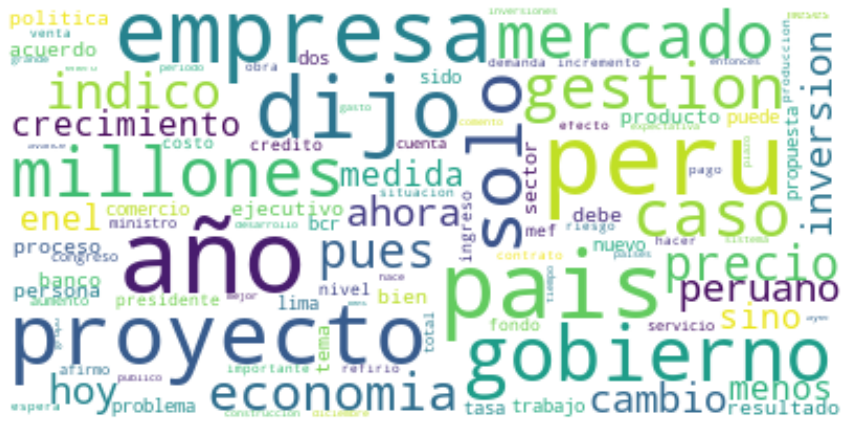

In [ ]:
### wordcloud de palabras recurrentes
plt.figure(figsize=(15,15))
wordcloud = WordCloud(max_words=100,min_font_size=5,max_font_size=50,background_color="white").generate(" ".join(df3["Clean_Stopword_Info"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

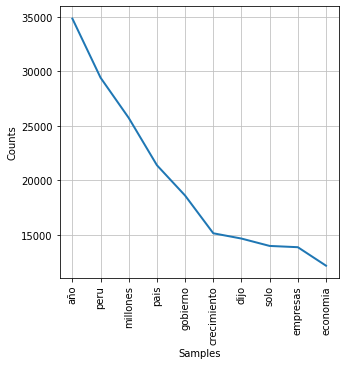

None


In [ ]:
## Histogramas de palabras mas frecuentes
plt.figure(figsize=(5,5))
frequencies = FreqDist( " ".join(df3["Clean_Stopword_Info"]).split() )
plot = frequencies.plot( 10 )
print(plot)

In [ ]:
## Mostrando los ngramas
Ngrams  = ngrams(" ".join(df3["Clean_Stopword_Info"]).split(), 1)
frequencies = FreqDist( Ngrams )
frequencies.most_common(100)

[(('año',), 34821),
 (('peru',), 29406),
 (('millones',), 25718),
 (('pais',), 21386),
 (('gobierno',), 18606),
 (('crecimiento',), 15150),
 (('dijo',), 14666),
 (('solo',), 13991),
 (('empresas',), 13875),
 (('economia',), 12180),
 (('años',), 11872),
 (('inversion',), 11390),
 (('bcr',), 10531),
 (('proyecto',), 10327),
 (('gestion',), 10109),
 (('mercado',), 9570),
 (('banco_central',), 8880),
 (('enel',), 8584),
 (('indico',), 8073),
 (('sector',), 8033),
 (('caso',), 7974),
 (('proyectos',), 7818),
 (('soles',), 7741),
 (('lima',), 7707),
 (('meses',), 7468),
 (('mes',), 7177),
 (('pues',), 7151),
 (('congreso',), 7018),
 (('menos',), 6907),
 (('empresa',), 6902),
 (('ahora',), 6878),
 (('hoy',), 6706),
 (('presidente',), 6541),
 (('pbi',), 6390),
 (('nacional',), 6357),
 (('precios',), 6267),
 (('dolares',), 6229),
 (('sino',), 6218),
 (('promedio',), 5926),
 (('dos',), 5923),
 (('total',), 5906),
 (('comercio',), 5874),
 (('aumento',), 5781),
 (('produccion',), 5778),
 (('nivel'

In [ ]:
df3.to_pickle("../data/cleaned/df_noticias_bcrp_cleanedInfo_trigrams.pkl")

In [ ]:
df_statistics.to_pickle("../data/intermediated/df_statistics_bcrp_trigrams.pkl")